# Netzsimulation mit Pandapower und Simbench

In [67]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandapower as pp
import pandas as pd
import simbench as sb
from pandapower.timeseries import OutputWriter, run_timeseries

## Pandapower Basics

Pandapower ist eine Bibliothek zur Berechnung/Simulation von Stromnetzen.
Es verwendet pandas und [PYPOWER](https://github.com/rwl/PYPOWER) um Netzwerkberechnungen zu ermöglichen.

* Website: http://www.pandapower.org/
* Dokumentation: https://pandapower.readthedocs.io/en/latest/about.html.
* Tutorials: https://nbviewer.org/github/e2nIEE/pandapower/tree/develop/tutorials/.

Konvention fuer Namen von Einheiten: \<parameter\>\_\<unit\> oder \<parameter\>\_\<phase\>\_\<unit\>. Beispiel: vn_kv -> $v_n[kV]$. Naehere Infos in Function Docstring oder in der Dokumentation.

Als erstes bauen wir ein minimales Netz aus einzelnen Komponenten auf.

In [2]:
# create empty net
my_net = pp.create_empty_network()

In [3]:
my_net

This pandapower network is empty

In [4]:
# create buses
bus1 = pp.create_bus(my_net, vn_kv=20.0, name="Bus 1")
bus2 = pp.create_bus(my_net, vn_kv=0.4, name="Bus 2")
bus3 = pp.create_bus(my_net, vn_kv=0.4, name="Bus 3")

In [5]:
my_net.bus

,name,vn_kv,type,zone,in_service
0,Bus 1,20.0,b,None,True
1,Bus 2,0.4,b,None,True
2,Bus 3,0.4,b,None,True


In [6]:
# The returned value is the index of the element in its table
print(type(bus1), bus1)

<class 'numpy.int64'> 0


In [7]:
# create bus elements
pp.create_ext_grid(
    my_net, bus=bus1, vm_pu=1.02, name="Grid Connection"
)  # erstellt externes netz
pp.create_load(my_net, bus=bus3, p_mw=0.100, q_mvar=0.05, name="Load")  # erstellt last

0

In [8]:
# create branch elements
trafo = pp.create_transformer(
    my_net, hv_bus=bus1, lv_bus=bus2, std_type="0.4 MVA 20/0.4 kV", name="Trafo"
)
line = pp.create_line(
    my_net,
    from_bus=bus2,
    to_bus=bus3,
    length_km=0.1,
    std_type="NAYY 4x50 SE",
    name="Line",
)

In [9]:
my_net

This pandapower network includes the following parameter tables:
   - bus (3 element)
   - load (1 elements)
   - ext_grid (1 elements)
   - line (1 elements)
   - trafo (1 elements)

In [10]:
my_net.line

,name,std_type,from_bus,to_bus,length_km,r_ohm_per_km,x_ohm_per_km,c_nf_per_km,g_us_per_km,max_i_ka,df,parallel,type,in_service
0,Line,NAYY 4x50 SE,1,2,0.1,0.642,0.083,210.0,0.0,0.142,1.0,1,cs,True


No or insufficient geodata available --> Creating artificial coordinates. This may take some time


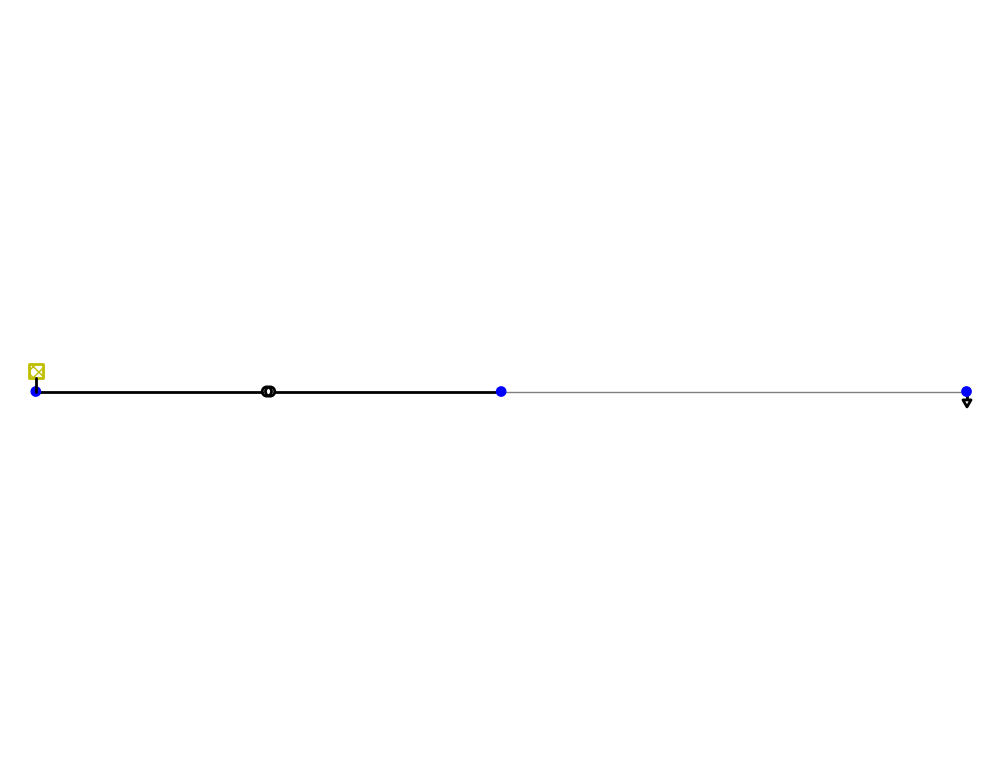

<Axes: >

In [11]:
pp.plotting.simple_plot(my_net, plot_loads=True, plot_gens=True, plot_sgens=True)

In [12]:
pp.runpp(my_net, numba=False)

In [14]:
my_net.res_bus

,vm_pu,va_degree,p_mw,q_mvar
0,1.020000,0.000000,-0.107265,-0.052675
1,1.008843,-0.760126,0.000000,0.000000
2,0.964431,0.115859,0.100000,0.050000


In [15]:
# Unit descriptions in https://pandapower.readthedocs.io/en/latest/elements/line.html#result-parameters
my_net.res_line

,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_from_ka,i_to_ka,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree,loading_percent
0,0.105392,0.050696,-0.1,-0.05,0.005392,0.000696,0.167325,0.167326,0.167326,1.008843,-0.760126,0.964431,0.115859,117.835208


## Beispielnetze und Simulation 

### Simples Pandapower Beispielnetz

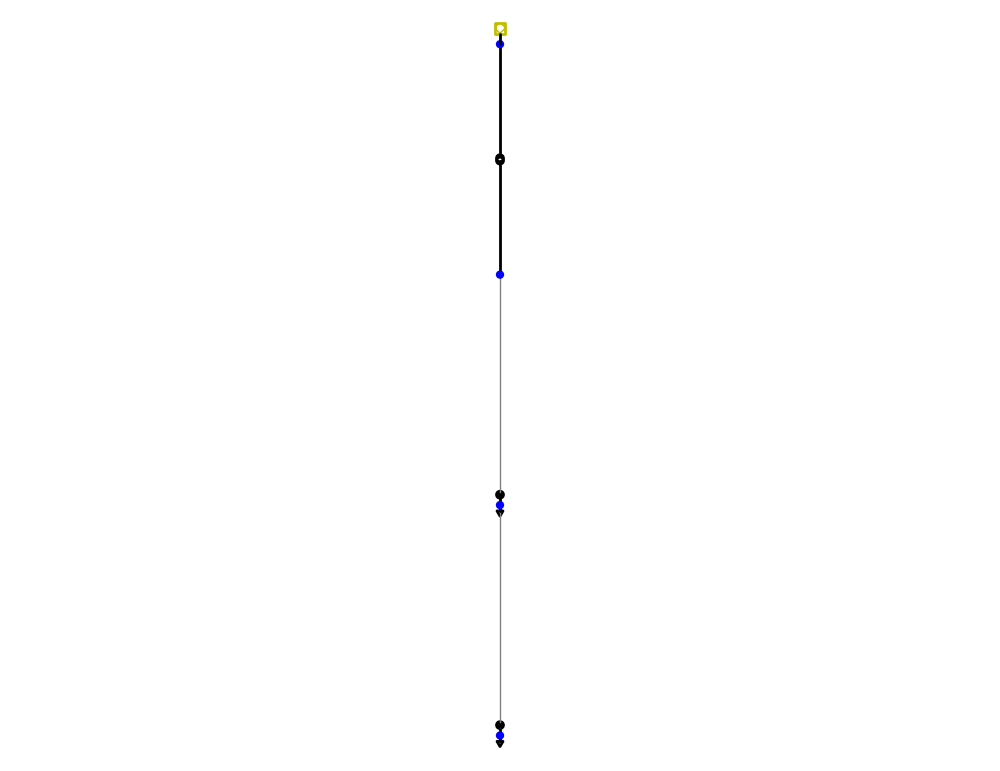

<Axes: >

In [87]:
# https://pandapower.readthedocs.io/en/latest/networks/test.html#pandapower.networks.simple_four_bus_system
small_net = pp.networks.simple_four_bus_system()
pp.plotting.simple_plot(small_net, plot_loads=True, plot_gens=True, plot_sgens=True)

In [88]:
small_net

This pandapower network includes the following parameter tables:
   - bus (4 element)
   - load (2 element)
   - sgen (2 element)
   - ext_grid (1 elements)
   - line (2 element)
   - trafo (1 elements)
   - bus_geodata (4 element)

In [89]:
small_net.load

,name,bus,p_mw,q_mvar,const_z_percent,const_i_percent,sn_mva,scaling,in_service,type
0,load1,2,0.03,0.01,0.0,0.0,NaN,1.0,True,wye
1,load2,3,0.03,0.01,0.0,0.0,NaN,1.0,True,wye


In [90]:
small_net.sgen

,name,bus,p_mw,q_mvar,sn_mva,scaling,in_service,type,current_source
0,pv1,2,0.020,0.005,0.03,1.0,True,wye,True
1,pv2,3,0.015,0.002,0.02,1.0,True,wye,True


### Zeitreihenberechnung mit Hilfe von pandapower

Basierend auf dem [Simple Time Series Example](https://github.com/e2nIEE/pandapower/blob/develop/tutorials/time_series.ipynb) Tutorial von pandapower, versuchen wir dieses simple Netz mit unseren vorher definierten Zeitreihen zu koppeln.

### Beispielnetz aus Simbench inklusive Beispielzeitreihen

Simbench bietet viele Beispielnetze für unterschiedlichste Szenarien an: https://simbench.de/de/datensaetze/.
(Link funktionierte bei mir nicht mit Firefox).

Dieses Beispiel Notebook gibt einen guten Überblick über die möglichen Nutzungen der Netzwerke gemeinsam mit pandapower:
https://github.com/e2nIEE/simbench/blob/master/tutorials/simbench_grids_basics_and_usage.ipynb.

In [46]:
# simbench - simbench.de - Zeitreihen von Verbrauchs/Einspeisedaten + Netze.
sb_code_lv = "1-LV-semiurb4--0-sw"

# creating a standard lv test network
net = sb.get_simbench_net(sb_code_lv)

C:\Users\z0041s8f\opt\Miniconda3\envs\fh312\Lib\site-packages\simbench\converter\csv_pp_converter.py:849: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_data[output_name] = pd.concat([output_data[output_name], input_data[
C:\Users\z0041s8f\opt\Miniconda3\envs\fh312\Lib\site-packages\simbench\converter\csv_pp_converter.py:849: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_data[output_name] = pd.concat([output_data[output_name], input_data[
C:\Users\z0041s8f\opt\Miniconda3\envs\fh312\

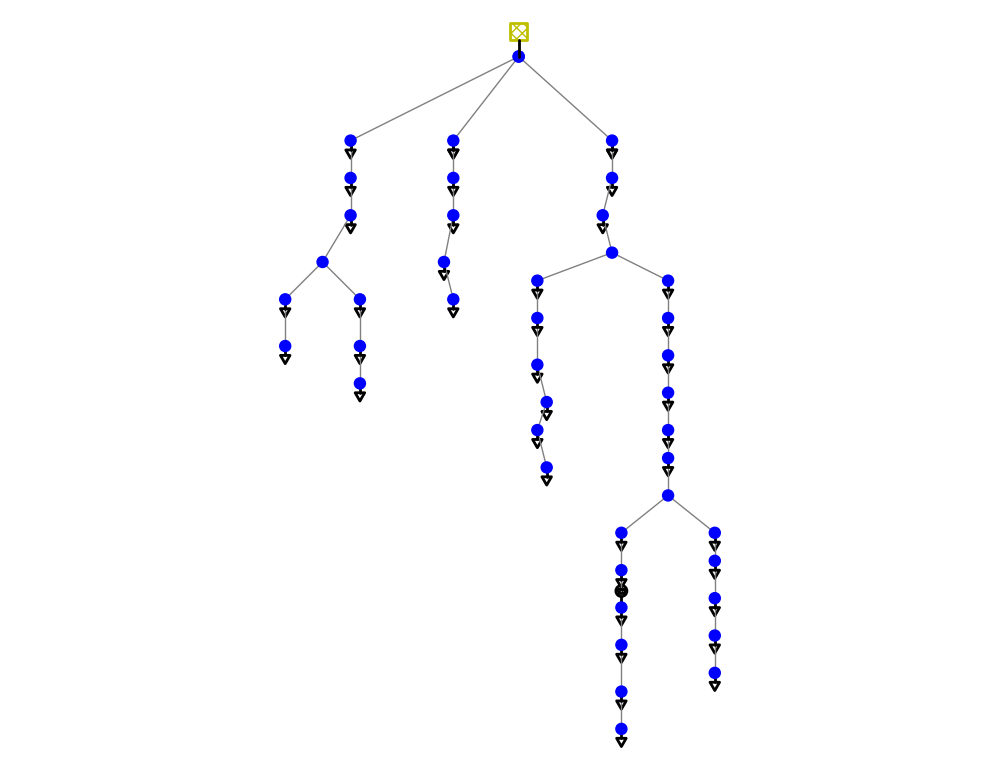

<Axes: >

In [47]:
pp.plotting.simple_plot(net, plot_loads=True, plot_gens=True, plot_sgens=True)

In [48]:
for key, df in net.profiles.items():
    print(f"{key}: {list(df.columns)}\n")

load: ['time', 'G1-A_qload', 'G1-A_pload', 'G1-C_qload', 'G1-C_pload', 'G2-A_qload', 'G2-A_pload', 'G4-A_qload', 'G4-A_pload', 'G4-B_qload', 'G4-B_pload', 'G6-A_qload', 'G6-A_pload', 'H0-A_qload', 'H0-A_pload', 'H0-B_qload', 'H0-B_pload', 'H0-G_qload', 'H0-G_pload', 'H0-L_qload', 'H0-L_pload']

powerplants: ['time']

renewables: ['time', 'PV5']

storage: ['time']



In [49]:
# Get PV data from simbench
pv = net.profiles["renewables"].copy()
pv.head()

,time,PV5
0,01.01.2016 00:00,0.0
1,01.01.2016 00:15,0.0
2,01.01.2016 00:30,0.0
3,01.01.2016 00:45,0.0
4,01.01.2016 01:00,0.0


In [50]:
# Make time the index, dayfirst for day.month.year and sort_index to allow slicing
pv.index = pd.to_datetime(pv["time"], dayfirst=True)
pv = pv["PV5"].sort_index()
pv.tail()

time
2016-12-31 22:45:00    0.0
2016-12-31 23:00:00    0.0
2016-12-31 23:15:00    0.0
2016-12-31 23:30:00    0.0
2016-12-31 23:45:00    0.0
Name: PV5, dtype: float64

<Axes: xlabel='time'>

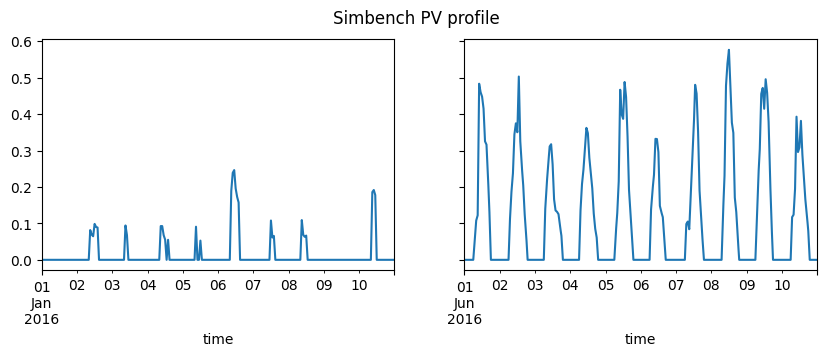

In [51]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
fig.suptitle("Simbench PV profile")
pv["2016-01-01":"2016-01-10"].plot(ax=axs[0])
pv["2016-06-01":"2016-06-10"].plot(ax=axs[1])

In [52]:
h0A = net.profiles["load"].set_index("time")["H0-A_pload"].copy()
h0A.index = pd.to_datetime(h0A.index, dayfirst=True)
h0A = h0A.sort_index()

<Axes: xlabel='time'>

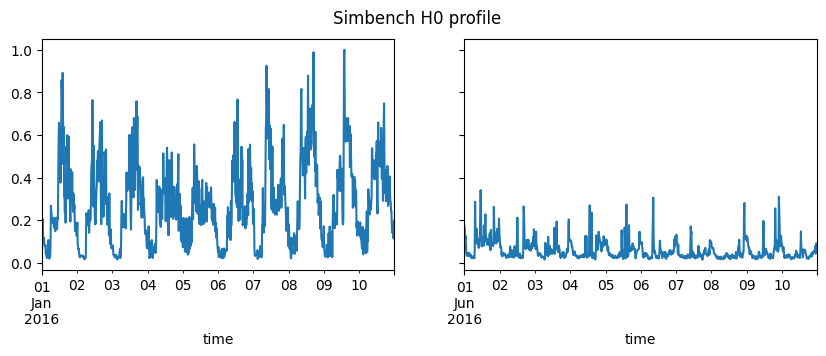

In [53]:
fig, axs = plt.subplots(1, 2, figsize=(10, 3), sharey=True)
fig.suptitle("Simbench H0 profile")
h0A["2016-01-01":"2016-01-10"].plot(ax=axs[0])
h0A["2016-06-01":"2016-06-10"].plot(ax=axs[1])

### Run timeseries analysis with predefined profiles

After [tutorial](https://github.com/e2nIEE/simbench/blob/master/tutorials/simbench_grids_basics_and_usage.ipynb).

In [54]:
# Check that all profiles exist
assert not sb.profiles_are_missing(net)

In [55]:
profiles = sb.get_absolute_values(net, profiles_instead_of_study_cases=True)

In [65]:
# Apply ConstControllers
sb.apply_const_controllers(net, profiles)
# Define time steps for 1 day
time_steps = range(0, 96)

In [86]:
# Create Output writer
output_dir = Path("./outputs")
output_dir.mkdir(exist_ok=True)
output_dir = output_dir / "simbench_ts_run"
# Using json here, as csv has non standard formatting, could also use .xls
ow = OutputWriter(net, time_steps, output_path=output_dir, output_file_type=".json")
ow.log_variable("res_load", "p_mw", eval_function=np.sum, eval_name="Load Sum")
ow.log_variable("res_bus", "vm_pu", eval_function=np.min, eval_name="min_vm_pu")
ow.log_variable("res_bus", "vm_pu", eval_function=np.max, eval_name="max_vm_pu")

In [85]:
run_timeseries(net, time_steps, numba=False)

100%|██████████████████████████████████████| 96/96 [00:02<00:00, 45.72it/s]


In [91]:
# Read Results and create DataFrame
vm_pu_file = output_dir / "res_bus" / "vm_pu.json"
vm_pu = pd.read_json(vm_pu_file)
ll_file = output_dir / "res_line" / "loading_percent.json"
line_loading = pd.read_json(ll_file)
load_p_file = output_dir / "res_load" / "p_mw.json"
load_p = pd.read_json(load_p_file)

C:\Users\z0041s8f\AppData\Local\Temp\ipykernel_27752\1055693763.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  vm_pu = pd.read_json(vm_pu_file)
C:\Users\z0041s8f\AppData\Local\Temp\ipykernel_27752\1055693763.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.
  vm_pu = pd.read_json(vm_pu_file)
C:\Users\z0041s8f\AppData\Local\Temp\ipykernel_27752\1055693763.py:3: FutureWarning: The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, stri

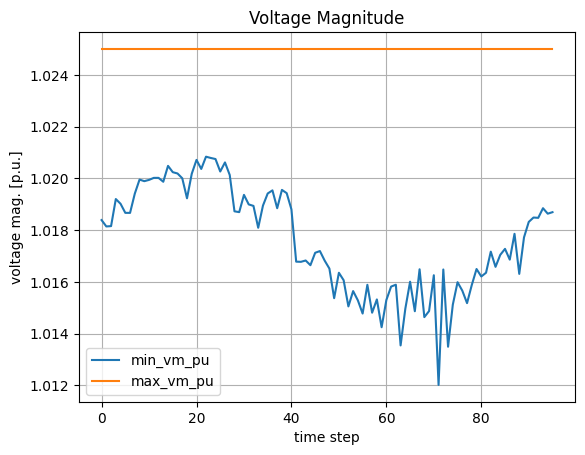

In [99]:
# Plot line loading
vm_pu[['min_vm_pu', 'max_vm_pu']].plot()
plt.xlabel("time step")
plt.ylabel("voltage mag. [p.u.]")
plt.title("Voltage Magnitude")
plt.grid()

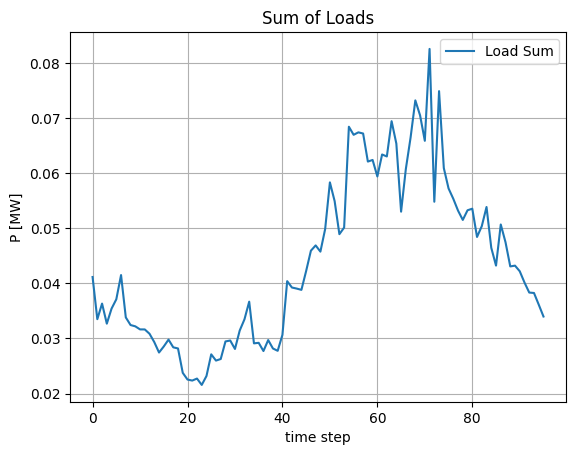

In [107]:
# load results
load_p.sort_index().plot()
plt.xlabel("time step")
plt.ylabel("P [MW]")
plt.title("Sum of Loads")
plt.grid()
plt.show()